In [2]:
from metalib.utils import load_hist_data
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [48]:
ohlc = load_hist_data('XAGUSD', 2020)

In [49]:
tau = 60*24
k = 15*60

ohlc.loc[:, 'min_l'] = ohlc.iloc[:, 2].rolling(tau).min()
ohlc.loc[:, 'max_h'] = ohlc.iloc[:, 1].rolling(tau).max()
ohlc.loc[:, 'log_range'] = ohlc.loc[:, 'max_h'].apply(np.log) - ohlc.loc[:, 'min_l'].apply(np.log) 
ohlc.loc[:, 'hour'] = pd.DatetimeIndex(ohlc.index).hour
ohlc.loc[:, 'idx'] = np.arange(ohlc.shape[0])
ohlc = ohlc[ohlc.idx%k==0]

ohlc.loc[:, 'log_range_lag1'] = ohlc.loc[:, 'log_range'].shift(1)
ohlc.loc[:, 'log_range_lag2'] = ohlc.loc[:, 'log_range'].shift(2)
ohlc.loc[:, 'log_range_lag3'] = ohlc.loc[:, 'log_range'].shift(3)

In [50]:
ohlc = ohlc.dropna()

<Axes: >

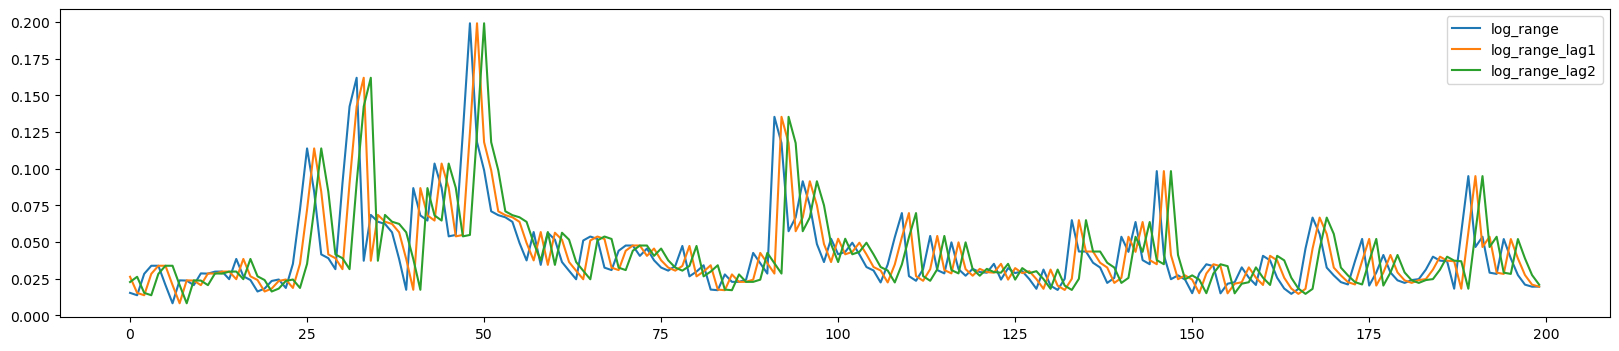

In [51]:
ohlc.iloc[-200:].loc[:, ['log_range', 'log_range_lag1', 'log_range_lag2']].reset_index(drop=True).plot(figsize=(20, 4))

<Axes: xlabel='log_range_lag1', ylabel='log_range'>

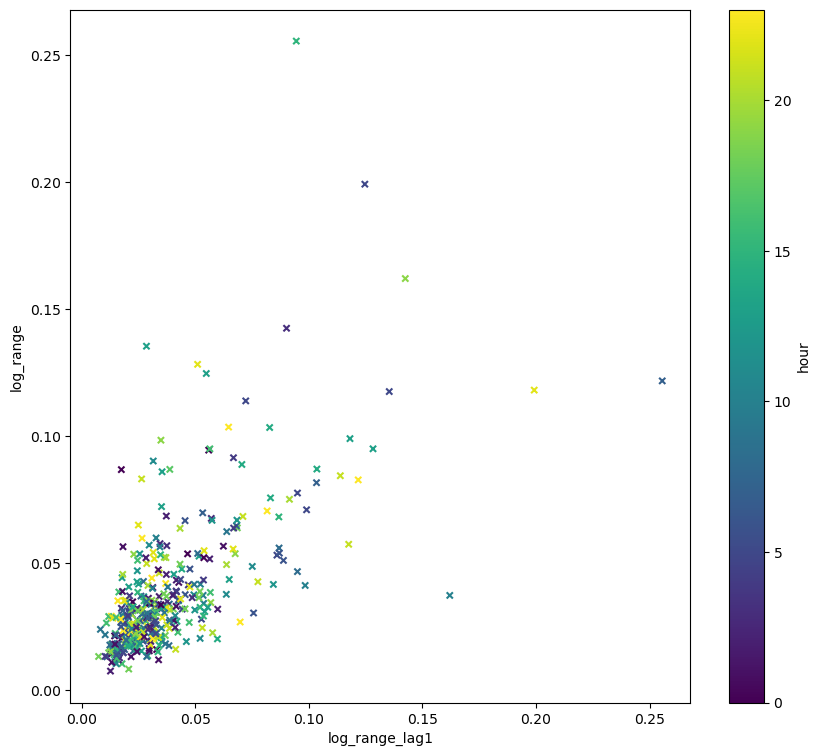

In [52]:
ohlc.plot.scatter(x='log_range_lag1', 
                  y='log_range', 
                  marker='x', 
                  c='hour', 
                  cmap='viridis', 
                  figsize=(10, 9)
                 )

# KAN

In [53]:
from kan import *
import torch

In [54]:
model = KAN(width=[3,2,1], grid=5, k=3, seed=0)

In [55]:
n = ohlc.shape[0]
n_train = int(0.7*n)

In [56]:
dataset = dict()
dataset['train_input'] = torch.Tensor(ohlc.iloc[:n_train].loc[:, ['log_range_lag1', 'log_range_lag2', 'log_range_lag3']].values)
dataset['train_label'] = torch.Tensor(ohlc.iloc[:n_train].loc[:, 'log_range'].values)
dataset['test_input'] = torch.Tensor(ohlc.iloc[n_train:].loc[:, ['log_range_lag1', 'log_range_lag2', 'log_range_lag3']].values)
dataset['test_label'] = torch.Tensor(ohlc.iloc[n_train:].loc[:, 'log_range'].values)

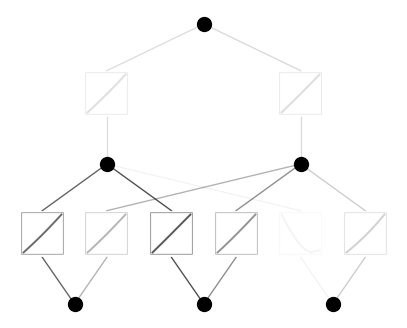

In [57]:
model(dataset['train_input']);
model.plot(beta=100)

In [58]:
model.train(dataset, opt="LBFGS", steps=50, lamb=0.01, lamb_entropy=10.);

train loss: 3.13e-02 | test loss: 2.12e-02 | reg: 1.37e+00 : 100%|██| 50/50 [00:16<00:00,  2.95it/s]


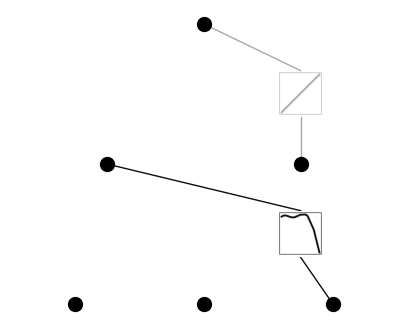

In [59]:
model.plot()

In [60]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[3,2,1], grid=5, k=3, seed=0)
    if i != 0:
        model = model = KAN(width=[3,2,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

train loss: 3.00e-02 | test loss: 2.00e-02 | reg: 6.74e+00 : 100%|██| 50/50 [00:05<00:00,  9.60it/s]
train loss: 3.00e-02 | test loss: 2.00e-02 | reg: 7.39e+00 :  86%|█▋| 43/50 [00:08<00:01,  5.04it/s]


KeyboardInterrupt: 

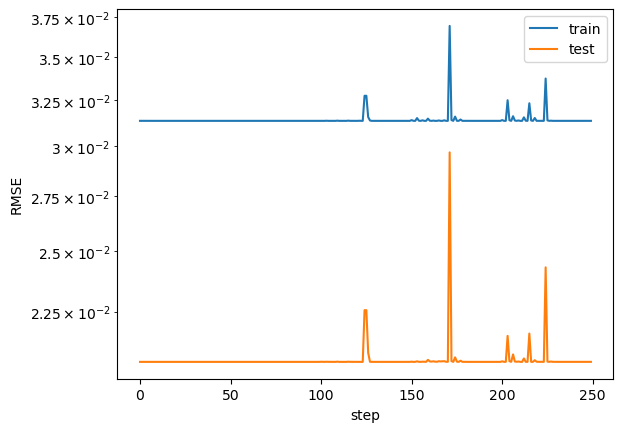

In [44]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')